# Uso de la red neuronal para la detección de monos


## 1. Dependecias

In [1]:
!pip install torch torchvision pillow huggingface_hub


## 2. Descagar modelo y labels

In [2]:
from pathlib import Path
from huggingface_hub import snapshot_download
import os

# Define tu token de lectura en el entorno antes de ejecutar esta celda:
# Linux/Mac: export HF_TOKEN_READ=hf_xxx
# Windows (PowerShell): setx HF_TOKEN_READ "hf_xxx"
# Colab/notebook temporal: os.environ["HF_TOKEN_READ"] = "hf_xxx"

HF_TOKEN = os.getenv("HF_TOKEN_READ")
assert HF_TOKEN, "⚠️ Define HF_TOKEN_READ en el entorno antes de ejecutar esta celda."

REPO_ID = "Barearojojuan/monkey-classifier-pytorch"

local_dir = Path(snapshot_download(
    repo_id=REPO_ID,
    allow_patterns=["*.pth", "labels.txt"],
    token=HF_TOKEN
))

WEIGHTS = local_dir / "monkey_classifier_v0.1.pth"
LABELS = local_dir / "labels.txt"

print(f"Descargado a: {local_dir}")
print("Pesos existen:", WEIGHTS.exists(), "| labels existen:", LABELS.exists())



Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Descargado a: C:\Users\Usuario\.cache\huggingface\hub\models--Barearojojuan--monkey-classifier-pytorch\snapshots\ba07b51928511061f764ba8623562e12fcee498d
Pesos existen: True | labels existen: True


## 3. Definir clases y transformaciones

In [3]:
import torchvision.transforms as T
import torch

# Clases desde labels.txt
if LABELS.exists():
    classes = [l.strip() for l in LABELS.read_text().splitlines() if l.strip()]
else:
    classes = [
        "Mantled_howler","Patas_monkey","Bald_uakari","Japanese_macaque","Pygmy_marmoset",
        "White_headed_capuchin","Silvery_marmoset","Common squirrel_monkey",
        "Black_headed_night_monkey","Nilgiri_langur"
    ]

# Transformaciones (mismas que en tu código)
mean = [0.4363, 0.4328, 0.3291]
std  = [0.2129, 0.2075, 0.2038]

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(torch.tensor(mean), torch.tensor(std))
])


## 4. Cargar modelo

In [4]:
import torch
import torchvision.models as models
from collections.abc import Mapping

def load_model(weights_path, num_classes):
    # 1) Intentar TorchScript
    try:
        m = torch.jit.load(str(weights_path), map_location="cpu")
        m.eval()
        print("[INFO] Cargado como TorchScript")
        return m
    except Exception as e:
        print("[INFO] No es TorchScript:", e.__class__.__name__)

    # 2) Cargar el checkpoint con torch.load
    obj = torch.load(str(weights_path), map_location="cpu")

    # 2a) Si es un nn.Module pickled -> úsalo directamente
    if isinstance(obj, torch.nn.Module):
        obj.eval()
        print(f"[INFO] Checkpoint es nn.Module pickled: {obj.__class__.__name__}")
        return obj

    # 2b) Si es un dict, puede ser state_dict o contenerlo
    if isinstance(obj, Mapping):
        # A veces viene el módulo en 'model'
        if "model" in obj and isinstance(obj["model"], torch.nn.Module):
            m = obj["model"]
            m.eval()
            print(f"[INFO] Encontrado nn.Module en 'model': {m.__class__.__name__}")
            return m
        # Si no, asumir que es state_dict (posiblemente en 'state_dict')
        sd = obj.get("state_dict", obj)
    else:
        raise TypeError(f"Tipo de checkpoint inesperado: {type(obj)}")

    # 3) Probar backbones comunes con state_dict
    backbones = [
        ("resnet18", models.resnet18(weights=None)),
        ("resnet34", models.resnet34(weights=None)),
        ("efficientnet_b0", models.efficientnet_b0(weights=None)),
    ]

    last_err = None
    for name, model in backbones:
        try:
            if name.startswith("resnet"):
                in_features = model.fc.in_features
                model.fc = torch.nn.Linear(in_features, num_classes)
            else:  # efficientnet
                in_features = model.classifier[-1].in_features
                model.classifier[-1] = torch.nn.Linear(in_features, num_classes)

            missing, unexpected = model.load_state_dict(sd, strict=False)
            print(f"[INFO] Cargado con {name}: missing={len(missing)}, unexpected={len(unexpected)}")
            model.eval()
            return model
        except Exception as e:
            last_err = e
            print(f"[WARN] Falló con {name}: {e}")

    raise RuntimeError(f"No se pudo cargar el modelo con los intentos realizados. Último error: {last_err}")

model = load_model(WEIGHTS, len(classes))



[INFO] No es TorchScript: RuntimeError
[INFO] Checkpoint es nn.Module pickled: ResNet


C:\Users\Usuario\AppData\Local\Temp\ipykernel_25996\1450341613.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  obj = torch.load(str(weights_path), map_location="cpu")


## 5. Inferencia sobre una imagen local

=== Resumen de Inferencia ===
Imagen: C:\Users\Usuario\Desktop\PROYECTOS\monoagent-langgraph\cajon_ de sastre\vc_pruebas\bald_monkey.jpg  (800x800)
Predicción: cacajao_calvus  |  confianza: 1.0000
Entropía: 0.0002
Top-5:
   1. cacajao_calvus                 1.0000  █████████████████████████████████████████████████
   2. alouatta_palliata              0.0000  
   3. cebus_capucinus                0.0000  
   4. macaca_fuscata                 0.0000  
   5. cebuella_pygmea                0.0000  

Tensor stats  ->  min: -1.8590  max: 3.1573  mean: -0.2774  std: 0.9671
Tiempos (ms)  ->  preprocess: 10.77  inference: 21.71  total: 32.48


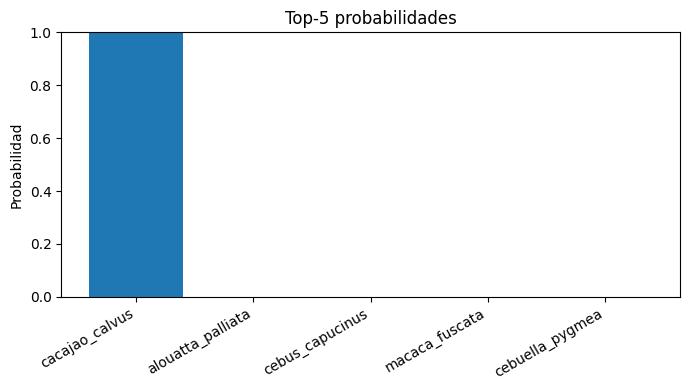

In [11]:
from pathlib import Path
from PIL import Image
import time, torch

@torch.inference_mode()
def predict_details(
    model,
    image_path,
    transform,
    classes,
    topk: int = 5,
    plot: bool = True
):
    t0 = time.perf_counter()

    # --- Cargar imagen y preprocesar ---
    img_path = Path(image_path)
    assert img_path.exists(), f"No existe: {img_path}"
    img = Image.open(img_path).convert("RGB")
    orig_w, orig_h = img.size

    x = transform(img).unsqueeze(0)  # [1, C, H, W]
    x_min, x_max = float(x.min().item()), float(x.max().item())
    x_mean = float(x.mean().item())
    x_std = float(x.std().item())

    # --- Inferencia ---
    t1 = time.perf_counter()
    logits = model(x)
    t2 = time.perf_counter()

    if isinstance(logits, (list, tuple)):
        logits = logits[0]
    probs = torch.softmax(logits, dim=1).squeeze(0)  # [num_classes]

    # --- Top-k ---
    k = min(int(topk), len(classes))
    top_vals, top_idxs = torch.topk(probs, k=k)
    top_idxs = top_idxs.tolist()
    top_vals = top_vals.tolist()
    top = [(classes[i], float(p)) for i, p in zip(top_idxs, top_vals)]

    # --- Predicción principal ---
    top1_idx = int(torch.argmax(probs).item())
    top1_label = classes[top1_idx]
    top1_conf = float(probs[top1_idx].item())

    # --- Métricas adicionales ---
    eps = 1e-12
    entropy = -float((probs * (probs + eps).log()).sum().item())
    logits_list = logits.squeeze(0).tolist() if logits.dim() == 2 else logits.tolist()

    preprocess_ms = (t1 - t0) * 1000
    infer_ms = (t2 - t1) * 1000
    total_ms = (t2 - t0) * 1000

    # --- Salida estructurada (devuelve por si lo necesitas en otra celda) ---
    result = {
        "image_path": str(img_path),
        "image_size": {"width": orig_w, "height": orig_h},
        "tensor_stats": {"min": x_min, "max": x_max, "mean": x_mean, "std": x_std},
        "prediction": {"label": top1_label, "index": top1_idx, "confidence": top1_conf},
        "topk": [{"label": lbl, "prob": float(p)} for lbl, p in top],
        "probs": {classes[i]: float(probs[i].item()) for i in range(len(classes))},
        "logits": {classes[i]: float(logits_list[i]) for i in range(len(classes))},
        "entropy": entropy,
        "timing_ms": {"preprocess": preprocess_ms, "inference": infer_ms, "total": total_ms}
    }

    # --- Mostrar resumen amigable ---
    print("=== Resumen de Inferencia ===")
    print(f"Imagen: {result['image_path']}  ({orig_w}x{orig_h})")
    print(f"Predicción: {top1_label}  |  confianza: {top1_conf:.4f}")
    print(f"Entropía: {entropy:.4f}")
    print("Top-{}:".format(k))
    for i, (lbl, p) in enumerate(top, 1):
        bar = "█" * int(50 * p)
        print(f"  {i:>2}. {lbl:<28} {p:>8.4f}  {bar}")

    print("\nTensor stats  ->  min: {min:.4f}  max: {max:.4f}  mean: {mean:.4f}  std: {std:.4f}".format(**result["tensor_stats"]))
    print("Tiempos (ms)  ->  preprocess: {preprocess:.2f}  inference: {inference:.2f}  total: {total:.2f}".format(**result["timing_ms"]))

    # --- Gráfico Top-k (si matplotlib disponible y plot=True) ---
    if plot:
        try:
            import matplotlib.pyplot as plt
            labels = [lbl for lbl, _ in top]
            values = [p for _, p in top]
            plt.figure(figsize=(7, 4))
            plt.bar(labels, values)
            plt.xticks(rotation=30, ha='right')
            plt.title(f"Top-{k} probabilidades")
            plt.ylabel("Probabilidad")
            plt.ylim(0, 1)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"(Aviso) No se pudo graficar Top-{k}: {e}")

    return result

# 🔽 Ruta segura en Windows (usa / o r"...")
test_image_path = r"C:\Users\Usuario\Desktop\PROYECTOS\monoagent-langgraph\cajon_ de sastre\vc_pruebas\bald_monkey.jpg"

# Ejecutar
res = predict_details(
    model=model,
    image_path=test_image_path,
    transform=transform,
    classes=classes,
    topk=5,
    plot=True
)



## 6. Exportar a TorchScript (+ guardar labels.json)

In [12]:
import json, hashlib, pathlib, textwrap
import torch

EXPORT_DIR = pathlib.Path("./export")
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

# 1) Exportar a TorchScript (seguro y portable)
model.eval()
example = torch.zeros(1, 3, 224, 224)  # ajusta si tu input difiere
scripted = torch.jit.trace(model, example)  # o torch.jit.script(model) si tu forward tiene control-flow
ts_path = EXPORT_DIR / "monkey_classifier_ts-v0.1.pt"
scripted.save(str(ts_path))

# 2) Guardar metadatos/labels (convenciones estándar)
meta = {
  "id2label": { str(i): name for i, name in enumerate(classes) },
  "label2id": { name: i for i, name in enumerate(classes) },
  "input_size": [1, 3, 224, 224],
  "normalize": {
    "mean": [0.4363, 0.4328, 0.3291],
    "std":  [0.2129, 0.2075, 0.2038]
  },
  "version": "v0.1"
}
labels_json = EXPORT_DIR / "labels.json"
with open(labels_json, "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

# 3) Checksum para integridad
sha = hashlib.sha256(open(ts_path, "rb").read()).hexdigest()

# 4) Explicación rápida (por qué exportamos de .pth a TorchScript)
explanation = textwrap.dedent("""
    ¿Por qué exportamos de .pth (pickled nn.Module) a TorchScript (.pt)?

    - Seguridad: torch.load con objetos pickled puede ejecutar código en deserialización. TorchScript evita pickle.
    - Portabilidad: un .pth pickled depende de versión exacta de PyTorch/torchvision y del código Python de la clase.
      En servidores (como Hugging Face Spaces) puede romper. TorchScript es mucho más estable/cruzado.
    - Simplicidad de despliegue: TorchScript se carga con torch.jit.load sin imports especiales de tu clase,
      reduce dependencias y acelera el arranque.
    - Reproducibilidad: junto con labels.json (id2label/label2id/normalización/tamaño), el artefacto queda autocontenido.

    Conclusión: para demo y producción ligera en Spaces, TorchScript + labels.json es la práctica recomendada.
""").strip()

print("✅ Exportación completada")
print("Guardados:")
print(" -", ts_path)
print(" -", labels_json)
print("SHA256:", sha)
print()
print(explanation)


✅ Exportación completada
Guardados:
 - export\monkey_classifier_ts-v0.1.pt
 - export\labels.json
SHA256: add7e70b8e8786017b1549d388fb405a549d9986e91a56cc1f19aeca690b55c6

¿Por qué exportamos de .pth (pickled nn.Module) a TorchScript (.pt)?

- Seguridad: torch.load con objetos pickled puede ejecutar código en deserialización. TorchScript evita pickle.
- Portabilidad: un .pth pickled depende de versión exacta de PyTorch/torchvision y del código Python de la clase.
  En servidores (como Hugging Face Spaces) puede romper. TorchScript es mucho más estable/cruzado.
- Simplicidad de despliegue: TorchScript se carga con torch.jit.load sin imports especiales de tu clase,
  reduce dependencias y acelera el arranque.
- Reproducibilidad: junto con labels.json (id2label/label2id/normalización/tamaño), el artefacto queda autocontenido.

Conclusión: para demo y producción ligera en Spaces, TorchScript + labels.json es la práctica recomendada.
